# 앙상블 (Ensemble)
- 다양한 모델을 결합하여 예측 성능을 향상시키는 방법
- 투표(Voting), 배깅(Bagging), 부스팅(Boosting), 스태킹(Stacking) 네 가지로 구분

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Voting
- hard voting : 여러 개의 예측치에 대해 다수결로 결정
- soft voting : 여러 개의 예측 확률을 평균내어 결정

##### 위스콘신 유방암 데이터셋 (Wisconsin Breast Cancer Dataset)

유방암의 악성(Malignant)과 양성(Benign)을 분류하기 위해 자주 사용되는 데이터셋
(의학적인 이미지를 바탕으로 유방암 종양의 특징을 수치화한 데이터)

**데이터셋 개요**
- **목적**: 유방암 종양이 악성(Malignant)인지, 양성(Benign)인지 분류
- **샘플 수**: 569개
- **특징(Features) 수**: 30개
- **타겟(Target)**: 0(악성) 또는 1(양성)

**데이터 구성**
1. **Radius mean**: 종양의 평균 반지름
2. **Texture mean**: 종양의 표면의 거칠기
3. **Perimeter mean**: 종양의 평균 둘레 길이
4. **Area mean**: 종양의 평균 면적
5. **Smoothness mean**: 종양의 매끄러움 정도
6. **Compactness mean**: 종양의 압축도
7. **Concavity mean**: 종양의 오목함
8. **Concave points mean**: 종양의 오목한 점 개수
9. **Symmetry mean**: 종양의 대칭성
10. **Fractal dimension mean**: 종양의 프랙탈 차원 

In [3]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
# print(data.DESCR)

df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [5]:
df['target'].value_counts()

target
1    357
0    212
Name: count, dtype: int64

In [6]:
# 데이터 준비 (분리)
from sklearn.model_selection import train_test_split

X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

##### hard voting

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

knn_clf = KNeighborsClassifier()
lr_clf = LogisticRegression()
dt_clf = DecisionTreeClassifier()

voting_clf = VotingClassifier(
    estimators=[
        ('knn_clf', knn_clf),
        ('lr_clf', lr_clf),
        ('dt_clf', dt_clf)
    ],
    voting='hard'    # 기본값
)

# 앙상블 모델 학습
voting_clf.fit(X_train, y_train)

# 예측 및 평가
y_pred_train = voting_clf.predict(X_train)
acc_score_train = accuracy_score(y_train, y_pred_train)
print('학습 점수:', acc_score_train)

y_pred_test = voting_clf.predict(X_test)
acc_score_test = accuracy_score(y_test, y_pred_test)
print('테스트 평가 점수:', acc_score_test)

학습 점수: 0.9647887323943662
테스트 평가 점수: 0.951048951048951


In [8]:
# hard voting 작동 원리 == 다수결
start, end = 40, 50

voting_clf_pred = voting_clf.predict(X_test[start:end])
print('앙상블 예측값:', voting_clf_pred)

for classfier in [knn_clf, lr_clf, dt_clf]:
    # 개별 학습 및 예측
    classfier.fit(X_train, y_train)
    pred = classfier.predict(X_test)
    acc_score = accuracy_score(y_test, pred)
    
    class_name = classfier.__class__.__name__    # 클래스의 이름 속성
    print(f'{class_name} 개별 정확도: {acc_score:.4f}')
    print(f'{class_name} 예측값: {pred[start:end]}')

앙상블 예측값: [0 1 0 1 0 0 1 1 1 0]
KNeighborsClassifier 개별 정확도: 0.9371
KNeighborsClassifier 예측값: [0 1 0 1 0 0 1 1 1 0]
LogisticRegression 개별 정확도: 0.9441
LogisticRegression 예측값: [0 1 0 1 0 0 1 1 1 0]
DecisionTreeClassifier 개별 정확도: 0.9021
DecisionTreeClassifier 예측값: [0 1 0 1 0 0 1 0 1 0]


##### soft voting

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

knn_clf = KNeighborsClassifier()
lr_clf = LogisticRegression()
dt_clf = DecisionTreeClassifier(random_state=0)

voting_clf = VotingClassifier(
    estimators=[
        ('knn_clf', knn_clf),
        ('lr_clf', lr_clf),
        ('dt_clf', dt_clf)
    ],
    voting='soft'
)

# 앙상블 모델 학습
voting_clf.fit(X_train, y_train)

# 예측 및 평가
y_pred_train = voting_clf.predict(X_train)
acc_score_train = accuracy_score(y_train, y_pred_train)
print('학습 점수:', acc_score_train)

y_pred_test = voting_clf.predict(X_test)
acc_score_test = accuracy_score(y_test, y_pred_test)
print('테스트 평가 점수:', acc_score_test)

학습 점수: 0.9859154929577465
테스트 평가 점수: 0.9370629370629371


In [10]:
# soft voting 작동 원리 == 각 예측기의 확률값 평균

start, end = 40, 50

voting_clf_pred_proba = voting_clf.predict_proba(X_test[start:end])
print('앙상블 예측값:', voting_clf_pred_proba)

averages = np.full_like(voting_clf_pred_proba, 0)

for classfier in [knn_clf, lr_clf, dt_clf]:
    # 개별 학습 및 예측
    classfier.fit(X_train, y_train)
    pred = classfier.predict(X_test)
    acc_score = accuracy_score(y_test, pred)
    pred_proba = classfier.predict_proba(X_test[start:end])

    # 예측 확률 평균을 위한 합계
    averages += pred_proba
    
    class_name = classfier.__class__.__name__    # 클래스의 이름 속성
    # print(f'{class_name} 개별 정확도: {acc_score:.4f}')
    # print(f'{class_name} 예측 확률: {pred_proba}')

# 예측 확률 평균 계산 및 출력
calc_averages = averages / 3
print("각 모델별 예측값 평균:", calc_averages)
print(np.array_equal(voting_clf_pred_proba, calc_averages))

앙상블 예측값: [[5.70263157e-01 4.29736843e-01]
 [1.08113730e-03 9.98918863e-01]
 [9.99622506e-01 3.77494355e-04]
 [3.35757426e-04 9.99664243e-01]
 [9.00993416e-01 9.90065841e-02]
 [1.00000000e+00 1.75163138e-13]
 [7.79971341e-05 9.99922003e-01]
 [1.83004552e-02 9.81699545e-01]
 [1.14568790e-03 9.98854312e-01]
 [9.32982089e-01 6.70179112e-02]]
각 모델별 예측값 평균: [[5.70263157e-01 4.29736843e-01]
 [1.08113730e-03 9.98918863e-01]
 [9.99622506e-01 3.77494355e-04]
 [3.35757426e-04 9.99664243e-01]
 [9.00993416e-01 9.90065841e-02]
 [1.00000000e+00 1.75163138e-13]
 [7.79971341e-05 9.99922003e-01]
 [1.83004552e-02 9.81699545e-01]
 [1.14568790e-03 9.98854312e-01]
 [9.32982089e-01 6.70179112e-02]]
True


### Bagging
- Bootstrap Aggregation
- Bootstrap 방식의 샘플링: 각 estimator 마다 훈련 데이터를 뽑을 때, 중복 값을 허용하는 방식
- 분류 모델의 경우, 각 tree(estimator)의 예측값을 다수결(hard voting) 결정
- 회귀 모델의 경우, 각 tree(estimator)의 예측값을 평균내어 결정
- 기본적으로 100개의 tree 사용

**하이퍼 파라미터**
| **하이퍼파라미터**      | **설명**                                                                                     | **기본값**      |
|--------------------------|--------------------------------------------------------------------------------------------|-----------------|
| `n_estimators`           | 생성할 트리의 개수 지정 (트리의 개수가 많을수록 성능이 좋아질 수 있지만 계산 비용 증가) | 100             |
| `criterion`              | 분할 품질을 측정하는 기준 (분류에서는 "gini" 또는 "entropy"를 사용)                 | "gini"          |
| `max_depth`              | 각 트리의 최대 깊이 (설정하지 않으면 트리는 잎 노드가 순수해질 때까지 계속 확장) | None            |
| `min_samples_split`      | 내부 노드를 분할하기 위해 필요한 최소 샘플 수 (과적합 방지 목적)                   | 2               |
| `min_samples_leaf`       | 잎 노드가 되기 위해 필요한 최소 샘플 수 (과적합 방지 목적)                          | 1               |
| `max_features`           | 각 트리를 분할할 때 고려할 최대 특성 수 ()"auto", "sqrt", "log2" 중 선택하거나, 특정 숫자 지정 가능) | "auto"          |
| `bootstrap`              | 각 트리를 만들 때 부트스트랩 샘플링을 사용할지 여부를 결정                               | True            |
| `random_state`           | 결과의 재현성을 위해 난수 시드 고정                                                  | None            |
| `n_jobs`                 | 병렬 계산을 위해 사용할 CPU 코어 수를 지정 (-1로 설정하면 모든 코어를 사용)           | None            |
| `class_weight`           | 각 클래스의 가중치를 자동으로 계산하거나 직접 지정 가능 (불균형 데이터 처리에 유용)    | None            |


In [11]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=0)

# 학습
rf_clf.fit(X_train, y_train)

# 예측 및 평가
y_pred_train = rf_clf.predict(X_train)
acc_score_train = accuracy_score(y_train, y_pred_train)
print('학습 점수:', acc_score_train)

y_pred_test = rf_clf.predict(X_test)
acc_score_test = accuracy_score(y_test, y_pred_test)
print('테스트 평가 점수:', acc_score_test)

학습 점수: 0.9976525821596244
테스트 평가 점수: 0.9790209790209791


In [16]:
# 100개의 DecisionTree 확인
# print(rf_clf.estimators)

# 100개의 DescisionTree가 사용한 샘플데이터 확인
# print(len(rf_clf.estimators_samples_[0]))

for i, sample_indexs in enumerate(rf_clf.estimators_samples_):
    print(f'{i}번째 DecesionTree의 샘플 인덱스: {sorted(sample_indexs)}')

0번째 DecesionTree의 샘플 인덱스: [np.int32(0), np.int32(0), np.int32(1), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(12), np.int32(12), np.int32(13), np.int32(16), np.int32(16), np.int32(16), np.int32(20), np.int32(22), np.int32(22), np.int32(24), np.int32(25), np.int32(25), np.int32(26), np.int32(31), np.int32(32), np.int32(32), np.int32(32), np.int32(35), np.int32(36), np.int32(36), np.int32(36), np.int32(38), np.int32(38), np.int32(40), np.int32(41), np.int32(41), np.int32(44), np.int32(45), np.int32(49), np.int32(49), np.int32(49), np.int32(53), np.int32(53), np.int32(55), np.int32(56), np.int32(56), np.int32(56), np.int32(57), np.int32(57), np.int32(57), np.int32(57), np.int32(59), np.int32(59), np.int32(60), np.int32(60), np.int32(62), np.int32(63), np.int32(63), np.int32(64), np.int32(65), np.int32(65), np.int32(66), np.int32(66), np.int32(66), np.int32(71), np.int32(72), np.int32(73), np.int32(75), np.int32(76), np.int32(77), np.

In [49]:
# 특성 중요도 확인
feat_imptc_ser = pd.Series(rf_clf.feature_importances_, index=data.feature_names).sort_index(ascending=False)
feat_imptc_ser


worst texture              0.014562
worst symmetry             0.012320
worst smoothness           0.013452
worst radius               0.117308
worst perimeter            0.163547
worst fractal dimension    0.009725
worst concavity            0.038035
worst concave points       0.114409
worst compactness          0.012360
worst area                 0.061882
texture error              0.006609
symmetry error             0.004600
smoothness error           0.003213
radius error               0.029419
perimeter error            0.014571
mean texture               0.016010
mean symmetry              0.006366
mean smoothness            0.007140
mean radius                0.024379
mean perimeter             0.054363
mean fractal dimension     0.003899
mean concavity             0.056032
mean concave points        0.103391
mean compactness           0.008854
mean area                  0.048603
fractal dimension error    0.004589
concavity error            0.006181
concave points error       0

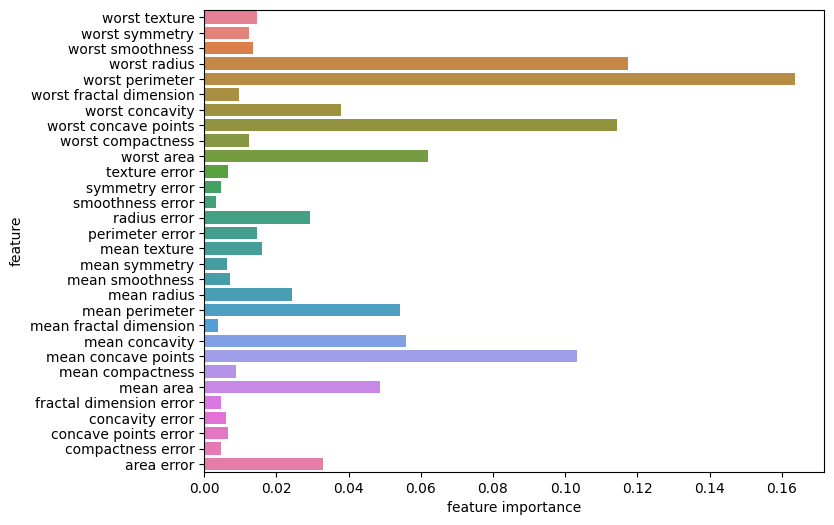

In [24]:
# 특성 중요도 시각화
plt.figure(figsize=(8, 6))
sns.barplot(
    x=feat_imptc_ser,
    y=feat_imptc_ser.index,
    hue=feat_imptc_ser.index
)
plt.xlabel('feature importance')
plt.ylabel('feature')
plt.show()

##### 와인데이터 셋 이진분류

0.9973316912972086 0.8830769230769231


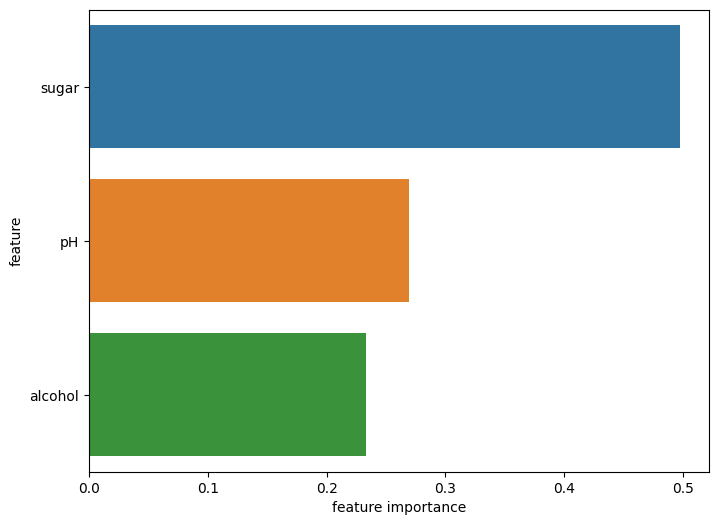

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# 1. 데이터 로드
wine_df = pd.read_csv('./data/wine_simple.csv')
wine_df
# 2. 데이터 분리
X = wine_df.drop('class', axis=1)
y = wine_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 3. RandomForestClassifier 모델 생성 및 학습
model = RandomForestClassifier()
model.fit(X_train, y_train)

# 4. 예측
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# 5. 정확도 출력
acc_score_train = accuracy_score(y_train, y_pred_train)
acc_score_test = accuracy_score(y_test, y_pred_test)

print(acc_score_train, acc_score_test)

# 6. 특성 중요도 시각화
feat_imptc_ser = pd.Series(model.feature_importances_, index=X.columns).sort_index(ascending=False)
feat_imptc_ser

plt.figure(figsize=(8, 6))
sns.barplot(
    x=feat_imptc_ser,
    y=feat_imptc_ser.index,
    hue=feat_imptc_ser.index
)
plt.xlabel('feature importance')
plt.ylabel('feature')
plt.show()


##### 인간행동인식 다중분류

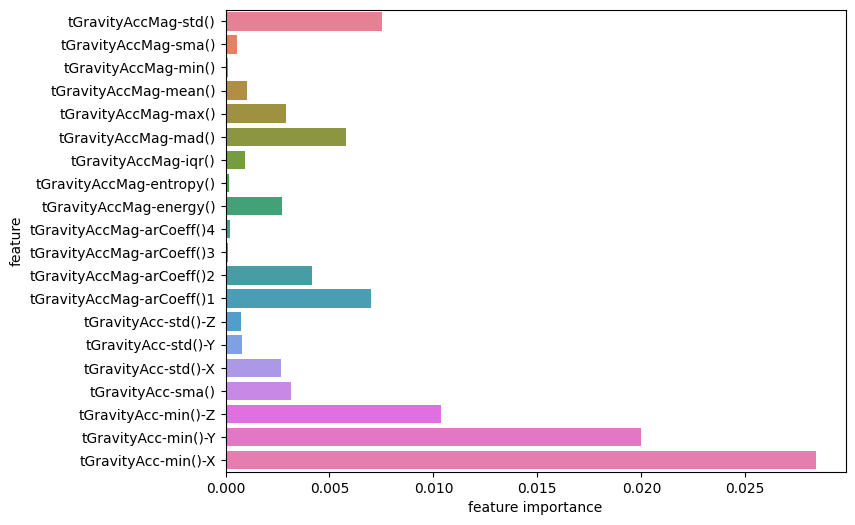

In [80]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 데이터 로드
human_train_df = pd.read_csv('./data/har_train.csv')
human_test_df = pd.read_csv('./data/har_test.csv')

# 데이터 분리
X_train = human_train_df.drop('Activity', axis=1)
X_test = human_test_df.drop('Activity', axis=1)
y_train = human_train_df['Activity']
y_test = human_test_df['Activity']


# 레이블 인코딩
encoder = LabelEncoder()
encoder.fit(X_train.columns)
encoder_label = encoder.transform(X_train.columns)

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# RandomForestClassifier 모델 학습
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)

# 모델 예측
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# # 예측

# 평가 (정확도)
acc_score_train = accuracy_score(y_train, y_pred_train)
acc_score_test = accuracy_score(y_test, y_pred_test)


# 특성 중요도 상위 20개 시각화
feat_imptc_ser = pd.Series(model.feature_importances_, index=X_train.columns).sort_index(ascending=False).head(20)
feat_imptc_ser

plt.figure(figsize=(8, 6))
sns.barplot(
    x=feat_imptc_ser,
    y=feat_imptc_ser.index,
    hue=feat_imptc_ser.index
)
plt.xlabel('feature importance')
plt.ylabel('feature')
plt.show()



정확도: 1.0


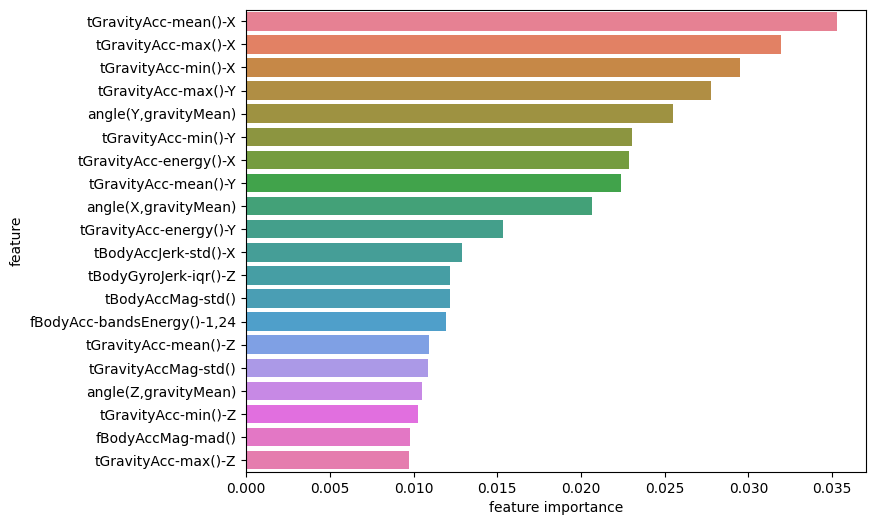

In [84]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 데이터 로드
human_train_df = pd.read_csv('./data/har_train.csv')
human_test_df = pd.read_csv('./data/har_test.csv')

# 데이터 분리
X_train = human_train_df.drop('Activity', axis=1)
X_test = human_test_df.drop('Activity', axis=1)
y_train = human_train_df['Activity']
y_test = human_test_df['Activity']


# 레이블 인코딩
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.fit_transform(y_test)

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# RandomForestClassifier 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train_encoded)

# 모델 예측
y_pred = model.predict(X_train_scaled)

# 평가 (정확도)
acc_score = accuracy_score(y_train_encoded, y_pred)
print(f'정확도: {acc_score}')

# 특성 중요도 상위 20개 시각화
feat_iptcs = model.feature_importances_
feat_names = X_train.columns

iptcs_df = pd.DataFrame({
    'Feature' : feat_names,
    'Importance' : feat_iptcs
}).sort_values(by='Importance', ascending=False).head(20)


plt.figure(figsize=(8, 6))
sns.barplot(
    x=iptcs_df['Importance'],
    y=iptcs_df['Feature'],
    hue=iptcs_df['Feature']
)
plt.xlabel('feature importance')
plt.ylabel('feature')
plt.show()



### Boosting
- 깊이가 얕은 결정트리를 사용해 이전 트리의 오차를 보정하는 방식
- 순차적으로 경사하강법을 사용해 이전 트리의 오차를 줄여나감
    - 분류모델에서는 손실함수 Lgogloss를 사용해 오차를 줄임
    - 회귀모델에서는 손실함수 MSE를 사용해 오차를 줄임
- Boosting 계열은 일반적으로 결정트리 개수를 늘려도 과적합에 강함
- 대표적인 알고리즘(모델): GrandientBoosting, HistGrandientBoosting, XGBoost, LightGBM, CatBoost

##### GradientBoosting

In [102]:
from sklearn.tree import DecisionTreeRegressor

class SimpleGradientBoostingClassifier:

    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.initial_log_odds = 0    # 초기 예측값
        self.trees = []    # estimator 모음 배열

    def log_odds(self, p):
        # 확률값 -> 로짓 변환 : 0~1 사이의 값을 펼쳐 -무한대~+무한대 사이의 값으로 보정
        return np.log(p / (1 - p))
    
    def sigmoid(self, z):
        # z값 -> 0~1 사이의 확률 값 변환
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # 초기 예측값 설정
        y_mean = np.mean(y)
        self.initial_log_odds = self.log_odds(y_mean)
        y_pred_log_odds = np.full_like(y, self.initial_log_odds, dtype=np.float64)

        # 모델 생성 및 학습
        for _ in range(self.n_estimators):
            # 현재 상태에서 예측된 확률값 계산
            y_pred_proba = self.sigmoid(y_pred_log_odds)

            # 잔차 계산
            residual = y - y_pred_proba

            # 결정트리 생성 및 학습
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residual)    # 잔차를 라벨로 학습
            self.trees.append(tree)

            # 예측값 업데이트 (예측값 점진적 개선)
            y_pred_log_odds += self.learning_rate * tree.predict(X)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

    def predict_proba(self, X):
        y_pred_log_odds = np.full((X.shape[0],), self.initial_log_odds)

        # 트리의 예측값을 누적하여 최종 로짓값 계산
        for tree in self.trees:
            y_pred_log_odds += self.learning_rate * tree.predict(X)
        
        return self.sigmoid(y_pred_log_odds)

In [104]:
# SimpleGradientBoostingClassifier 로 유방암 데이터 예측
from sklearn.ensemble import GradientBoostingClassifier

data= load_breast_cancer()

X_train,X_test,y_train,y_test = train_test_split(data.data, data.target, random_state=0)

simple_gb_df = SimpleGradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5
)

simple_gb_df.fit(X_train,y_train)

y_pred_train = simple_gb_df.predict(X_train)
y_pred_test = simple_gb_df.predict(X_test)

print(f'학습 정확도: {accuracy_score(y_train, y_pred_train)}')
print(f'평가 정확도 : {accuracy_score(y_test,y_pred_test)}')

학습 정확도: 0.9953051643192489
평가 정확도 : 0.9230769230769231


##### HistGradientBoosting
- 고성능 GradientBoosting 모델로 대규모 데이터셋 처리에 적합
- Historam 기반으로 256개의 구간으로 나누어 처리 병합하는 방식
- 결측치가 있어도 전처리가 필요 없음
- LightGBM의 영향을 받아 만들어진 scikit-learn의 모델

In [107]:
from sklearn.ensemble import HistGradientBoostingClassifier

data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=42)

hist_go_clf = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=3,
    max_bins=255, # 255개의 구간으로 나누어 처리 (1개는 결측치 전용)
    early_stopping=True, # 반복 중 일정 횟수 이상 성능 향상이 없으면 학습 종료
    n_iter_no_change=5 # '일정 횟수' 지정 (기본값: 10)
)
hist_go_clf.fit(X_train, y_train)

y_pred_train = hist_go_clf.predict(X_train)
y_pred_test = hist_go_clf.predict(X_test)
print(f'학습 정확도 : {accuracy_score(y_train, y_pred_train)}')
print(f'예측 정확도 : {accuracy_score(y_test, y_pred_test)}')

학습 정확도 : 0.9929577464788732
예측 정확도 : 0.958041958041958


In [110]:
from sklearn.inspection import permutation_importance

# 툭성 중요도 == permutation_importance
result = permutation_importance(
    hist_go_clf,
    X_train,
    y_train,
    n_repeats=5,
    random_state=0
)

# importances_mean == 평균 중요도
# importances_std == 중요도 표준편차
# importances
result.importances_mean

array([ 0.        ,  0.00798122,  0.        ,  0.00140845,  0.        ,
        0.        ,  0.        ,  0.00422535,  0.        ,  0.        ,
       -0.00093897,  0.        , -0.00046948,  0.0028169 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00046948,  0.00892019, -0.00093897,  0.00610329,  0.        ,
        0.        ,  0.00469484,  0.02253521, -0.00093897,  0.        ])

##### 회귀 모델

In [117]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

diabetes = load_diabetes()

X_train, X_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, random_state=0)

In [118]:
hist_gb_reg = HistGradientBoostingRegressor(
    max_iter=100, # 몇번 반복할지
    max_depth=3,
    learning_rate=0.05,
    random_state=0,
    l2_regularization=0.5, # l2 규제의 강도를 정해주는 값 기본값은 0
    min_samples_leaf=5
)
hist_gb_reg.fit(X_train, y_train)

y_pred_train = hist_gb_reg.predict(X_train)

y_pred_test = hist_gb_reg.predict(X_test)

print(f'학습 MSE : {mean_squared_error(y_train, y_pred_train)} | 학습 R2 : {r2_score(y_train, y_pred_train)}')
print(f'평가 MSE : {mean_squared_error(y_test, y_pred_test)} | 학습 R2 : {r2_score(y_test, y_pred_test)}')


학습 MSE : 1349.7927482181808 | 학습 R2 : 0.7841531432486148
평가 MSE : 3692.3791002557186 | 학습 R2 : 0.256230565040123


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_iter' : [100, 200, 300],
    'max_depth' : [1, 3, 5],
    'learning_rate' : [0.01, 0.05, 0.1],
    'min_samples_leaf' : [10, 20, 30],
    'l2_regularization' : [0.0, 0.1, 1.0],
    'max_bins' : [255, 127]
}

hist_gb_reg = HistGradientBoostingRegressor(random_state=0)
grid_search = GridSearchCV(hist_gb_reg, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

grid_search.best_params_ # 최고의 성능을 내는 하이퍼 파라미터

{'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'max_bins': 127,
 'max_depth': 1,
 'max_iter': 200,
 'min_samples_leaf': 20}

In [126]:
best_hist_gb_reg = grid_search.best_estimator_
# best_hist_gb_reg

y_pred_train = best_hist_gb_reg.predict(X_train)
y_pred_test = best_hist_gb_reg.predict(X_test)

print(f'학습 MSE : {mean_squared_error(y_train, y_pred_train)} | 학습 R2 : {r2_score(y_train, y_pred_train)}')
print(f'평가 MSE : {mean_squared_error(y_test, y_pred_test)} | 학습 R2 : {r2_score(y_test, y_pred_test)}')


학습 MSE : 2168.484353327469 | 학습 R2 : 0.653235259858844
평가 MSE : 3455.1451971700467 | 학습 R2 : 0.3040174583304508
